### See updated lesson plan and source code https://github.com/jennifer-bio/SIR_workshop
### Run code online with https://mybinder.org/v2/gh/jennifer-bio/SIR_workshop.git/master 

#### Notes on this notobook
The code is writen in R which is a "programming language and free software environment for statistical computing"

To run each grey block (cell), click on it and hit the 'run' button on the above tool bar - you need to run all of the cells otherwise the later cells will not work

When there is a '#', this is a comment which is not run as code but is meant for the user to read 


In [1]:

options(warn = -1) # Suppress warnings

#'library(X)' tells the compter to check all of the functions and terms in X referance library 
#this lets you use functions that you or others made 
library(reshape)
library(ggplot2)
library(dplyr)

options(repr.plot.width = 25, repr.plot.height = 8) # set plot size

#feel free the ignore the red box that will pop up

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'dplyr'

The following object is masked from 'package:reshape':

    rename

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



# Part 1: Introduction to epidemiology and the  SIR model 

    Before getting started with the activity we will introduce a little bit of background
    S: Susceptible (i.e. Healthy)
    I: Infectious (i.e. Infected)
    R: Removed (i.e. a person can be removed from population by vacine/dead/isolated quarantine)
    
    beta: transmission rate (susceptible -> infectious)
    gamma: removal rate (infectious -> remove)
    
    R-repoductive number: beta*S/gamma
    R0-Basic reporodcutive number: beta/gamma

# What's what: setting up the data 

In [2]:
beta  = 1.5   # transmission rate
gamma = 0.2   # removal rate

data = data.frame("S" = as.double(), "I" = as.double(), "R" = as.double()) #make table with col S I and R called data

#fills in table with 3 rows 
data["city_A",] = c(0.99, 0.01, 0) 
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)


data$city  = rownames(data)

#adds the same beta and gamma for each row
data$beta  = beta
data$gamma = gamma

#prints table below
data


,S,I,R,city,beta,gamma
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
city_A,0.99,0.01,0.0,city_A,1.5,0.2
city_B,0.80,0.10,0.1,city_B,1.5,0.2
city_C,0.50,0.20,0.3,city_C,1.5,0.2
city_D,0.60,0.30,0.1,city_D,1.5,0.2


# Modeling changes to the population over time

In [3]:

#this is a function, we can call time_step(data) at anypoint after running this code 
#it will do the steps listed in the '{}'

time_step = function(data){
    #data$city is a list of the values (the city names) stored in the city col of the data table, 
    #here we are saying do everything in the '{}' for each city
    #data['city_A'] refers to the row of data that is called 'city_A'
    #data['city_A', "S"] refers to the value that is in 'city_A' row and 'S' col
    for (city in data$city){
        S = data[city, "S"] # assign S
        I = data[city, "I"] # assign I
        R = data[city, "R"] # assign R
        
        beta  = data[city, "beta"] #saves the current value of beta for city as beta
        gamma = data[city, "gamma"]
        
        data[city, "S"] = S - beta*S*I           # change in S
        data[city, "I"] = I + beta*S*I - gamma*I # change in I
        data[city, "R"] = R + gamma*I            # change in R
    }
    
    return(data)
}


,S,I,R,city,beta,gamma
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
city_A,0.99,0.01,0.0,city_A,1.5,0.2
city_B,0.80,0.10,0.1,city_B,1.5,0.2
city_C,0.50,0.20,0.3,city_C,1.5,0.2
city_D,0.60,0.30,0.1,city_D,1.5,0.2


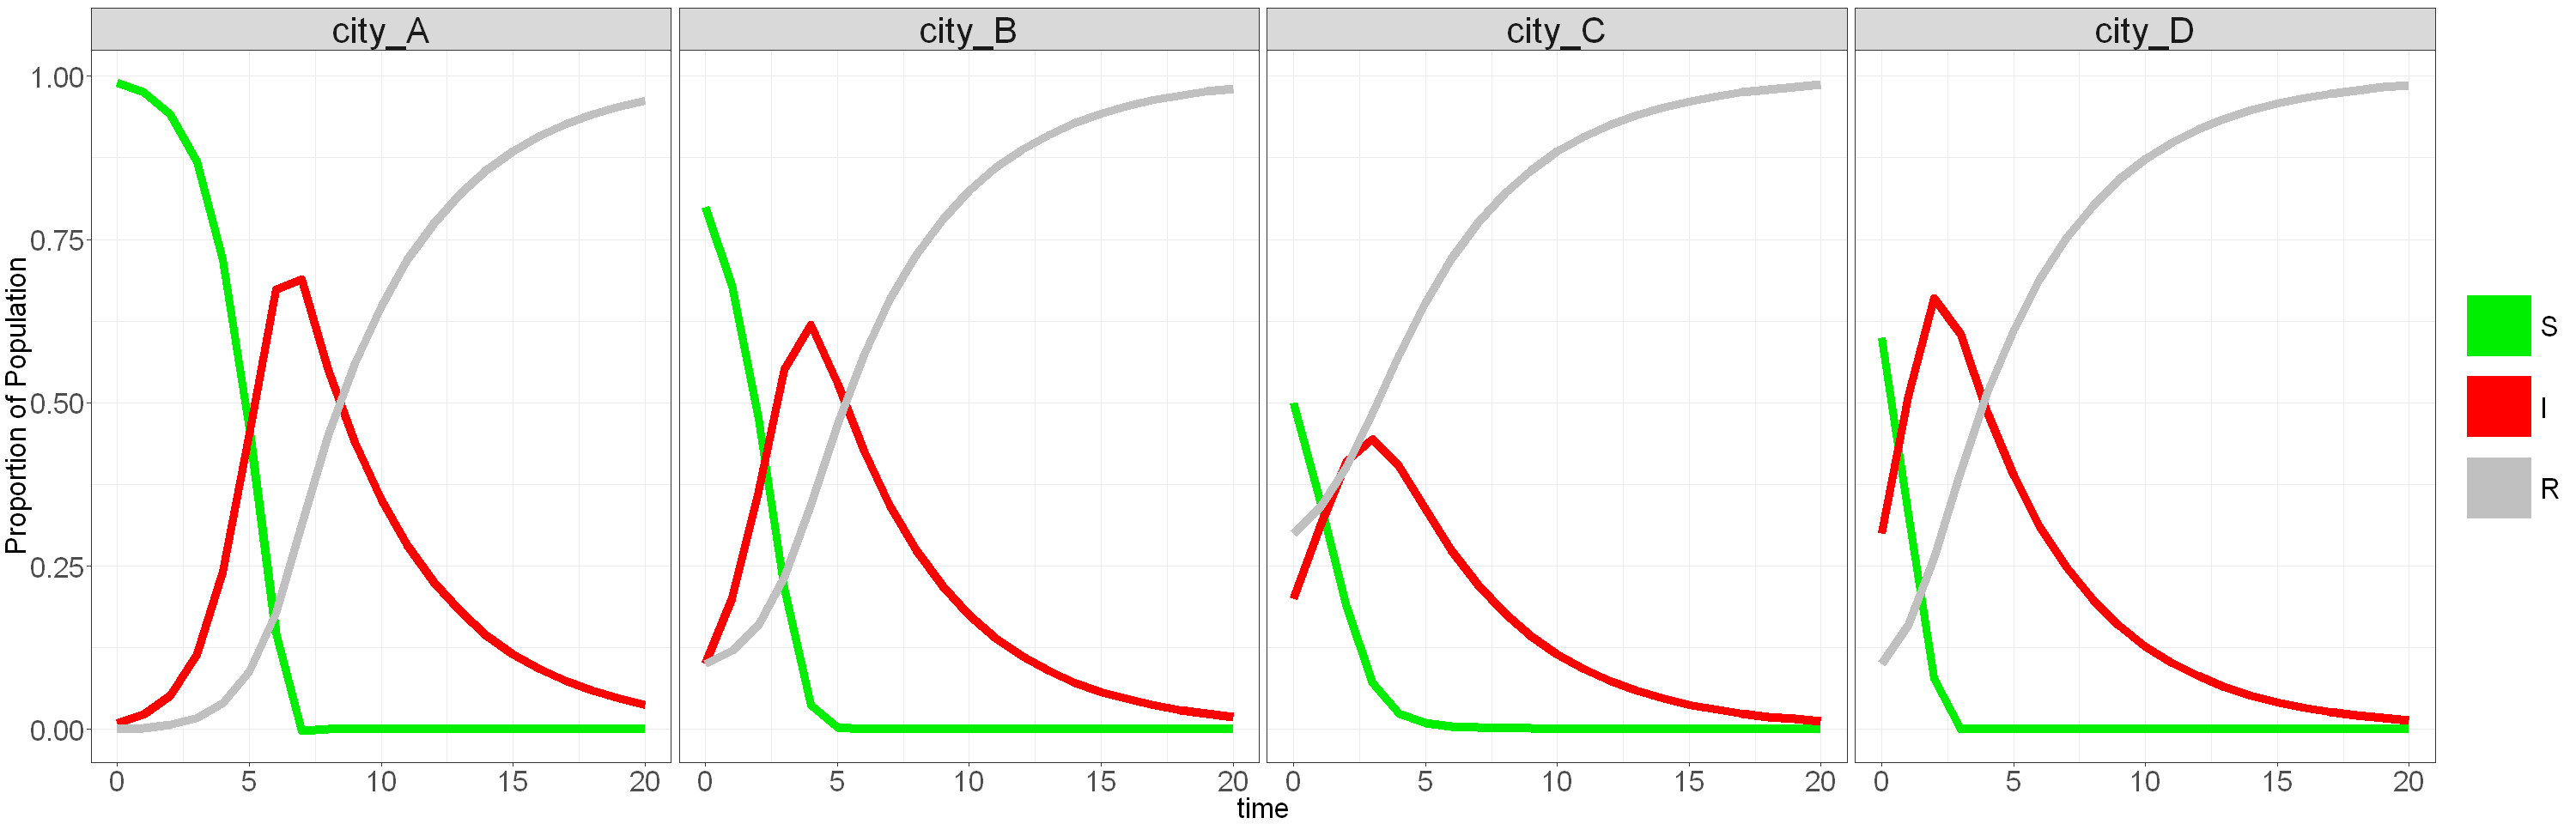

In [4]:
#run this cell with differnt paramters to see how things change due to parmaters

# 1. Setting up the data (as before) -----------------

beta  = 1.5   # transmission rate
gamma = 0.2   # recovery rate

data            = data.frame("S" = as.double(), "I" = as.double(), "R" = as.double())
data["city_A",] = c(0.99, 0.01, 0) 
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$city  = rownames(data)
data$beta  = beta
data$gamma = gamma

data

# 2. Model the dynamics over a given time -----------------

master      = data            # save starting values to master
master$time = 0               # add time column - starts at time 0 for each city 

for (i in 1:20){              # for each number in 1 though 20 time points - measured in months:
    a      = time_step(data)  # call function 'time_step' and save updated data table to "a"
    data   = a                # re-initialize "data"
    a$time = i                # add time column
    master = rbind(master, a) # save updated values (as recorded in a) to "master"
}

# 3. See the changes -----------------
#dont worry about all the weirdness here just know it makes pretty pictures

ggplot(melt(master[,c("S", "I", "R", "city", "time")], id = c("time", "city")), aes(x = time,  y = value, color = variable )) +  # assign x- and y-values
    geom_line(size = 3) +  theme_bw() + facet_grid(~city) +                       # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                         # increase axis text size     
          axis.title   = element_text(size = 20),                         # increase axis title size
          legend.text  = element_text(size = 20),                         # increase legent text size
          legend.title = element_blank(),                                 # remove title in legend
          strip.text   = element_text(size=25)) +                         # increase plot title size
    ylab("Proportion of Population") +                                    # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0")) +     # set colors
    guides(color = guide_legend(override = list(size = 20)))              # enlarge legend symbols



# Part 2: Shock to system
    
    Two types of events:
        1. Shock      (i.e. one instance)
        2. Behavorial (i.e. long-term change)
    
    Shock is a one-time event where transmission can occur (i.e. alters S and I)
    
        Example: concert
        
        - event_beta: the rate of transmission for one instance during event
        
            data[city, "S"] = data[city, "S"] - (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
            data[city, "I"] = data[city, "I"] + (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
        
            1. = 0: no change
            2. > 0: transmission during event
            
    Behavorial is an ongoing situation where tranmission/remove rates change (i.e. alters beta and/or gamma)
    
        Example: state opens, restaurants open
    
        - effect_of_beta: changes beta for the rest of simulation
        
            data[city, "beta"]  = data[city, "beta"]  * events[event, "effect_on_beta"]
        
            1. > 1: increases beta (i.e. higher tranmission rate)
            2. < 1: decreases beta (i.e. lower transmission rate)
            3. = 1: no change in beta
            
        - effect of gamma: changes gamma for rest of simulation
        
            data[city, "gamma"] = data[city, "gamma"] * events[event, "effect_on_gamma"]
            
            1. > 1: increases gamma (i.e. higher remove rate)
            2. < 1: decreases gamma (i.e. lower remove rate) 
            3. = 1: no change in gamma
    # Examples of events


#Defining event effects

In [26]:
# 1. Initialize table -----------------


#make a tabel with col names of 'event_name', 'type', ect.
events = data.frame("event_name"      = as.character("no_change"), 
                    "type"            = as.character("behavorial"), 
                    "effect_on_beta"  = 1, 
                    "effect_on_gamma" = 1, 
                    "event_beta"      = 0)


# 2. Add events -----------------



temp <- data.frame("concert"              , "shock"      , 1  , 1  , 2) #makes a row in a temporary table called temp
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta") #add names to that table 
                                                                                           # 'c()' collects everythin in brackets into a list
                                                                                           # that list is saved as the col names of temp table
events <- rbind(events, temp) #add temp table to main events table with 'rbind' (row bind)

temp <- data.frame("state_open"           , "behavorial" , 1.5, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("hospital_full"        , "behavorial" , 1  , 0.8, 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("improved_treatments"  , "behavorial" , 1  , 2, 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("natural_disaster"     , "shock"      , 1  , 1  , 4)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("distancing_compliance", "behavorial" , 0.5, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("vaccine"              , "behavorial" , 0.05, 1  , 0  )
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("civil_unrest"         , "shock"      , 1  , 1  , 3)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)

temp <- data.frame("schools_reopen_temp"  , "shock"      , 1  , 1  , 3)
names(temp) <- c("event_name" , "type", "effect_on_beta", "effect_on_gamma", "event_beta")
events <- rbind(events, temp)



# 3. Convert to numbers -----------------

events$effect_on_beta  = as.double(events$effect_on_beta) #changes effect_on_beta that was saved as words into double, which is a type of number for computers
events$effect_on_gamma = as.double(events$effect_on_gamma)
events$event_beta      = as.double(events$event_beta)
events$event_name      = as.character(events$event_name)
rownames(events) = events$event_name

events

,event_name,type,effect_on_beta,effect_on_gamma,event_beta
,<chr>,<fct>,<dbl>,<dbl>,<dbl>
no_change,no_change,behavorial,1.00,1.0,0
concert,concert,shock,1.00,1.0,2
state_open,state_open,behavorial,1.50,1.0,0
hospital_full,hospital_full,behavorial,1.00,0.8,0
improved_treatments,improved_treatments,behavorial,1.00,2.0,0
natural_disaster,natural_disaster,shock,1.00,1.0,4
distancing_compliance,distancing_compliance,behavorial,0.50,1.0,0
vaccine,vaccine,behavorial,0.05,1.0,0
civil_unrest,civil_unrest,shock,1.00,1.0,3


In [6]:
# Modeling changes in beta and gamma 
#setting up event funtinos

In [31]:
# This function selects a random event and applies it to a random city, changing its corresponding parameters (i.e. S, I, beta, gamma). 

event = function(data, time){   
    
    
    # You can use to get random events or pick the event by commenting (use '#') the line that you dont want to run
    #event = "vaccine" # sets event as value, chosen from event_name: here it is vaccine
    event = sample(events$event_name, 1) # Select random event the list of values in the event_name col of events
    
    # Select random city from the list of values in the city col of data
    city  = sample(data$city, 1)
    
    if (events[event, "type"] == "shock") { message("Shock!") }
    else { message("Behavior change!") }
    
    #if you do not want to see all the messages before the plots comment out (add '#') before all the lines with 'message'
    message(paste(event, "is happening in", city))
    
    message(paste("effect on beta:", events[event, "effect_on_beta"]))
    message(paste("effect on gamma:", events[event, "effect_on_gamma"]))
    message(paste("event_beta:", events[event, "event_beta"]))
    
    message("\n")
    
    # Change beta/gamma 
    
    message(paste("At time", time, ", if there had been no event: -------"))
    message(paste0(capture.output(data), collapse = "\n"))
    
    data[city, "beta"]  = data[city, "beta"]  * events[event, "effect_on_beta"]
    data[city, "gamma"] = data[city, "gamma"] * events[event, "effect_on_gamma"]
    
    data[city, "S"] = data[city, "S"] - (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
    data[city, "I"] = data[city, "I"] + (events[event, "event_beta"] * data[city, "S"] * data[city, "I"])
    
    message("But with event: -------")
    message(paste0(capture.output(data), collapse = "\n"))

    return(data)

}

# This function allows us to see how this shock impacts the city over time
time_step_event = function(data, time){
    
    data = event(data, time) #calls the event function with each time step (see above)
    
    for (city in rownames(data)){
        S = data[city, "S"]
        I = data[city, "I"]
        R = data[city, "R"]

        beta  = data[city, "beta"]
        gamma = data[city, "gamma"]
        
        data[city, "S"] = S - beta*S*I
        data[city, "I"] = I + beta*S*I - gamma*I
        data[city, "R"] = R + gamma*I

    }
    
    return(data)
}


# Running the shocks

Behavior change!
hospital_full is happening in city_B
effect on beta: 1
effect on gamma: 0.8
event_beta: 0


At time 1 , if there had been no event: -------
          S    I R beta gamma   city
city_A 0.99 0.01 0  1.5   0.2 city_A
city_B 0.99 0.01 0  1.5   0.2 city_B
city_C 0.99 0.01 0  1.5   0.2 city_C
city_D 0.99 0.01 0  1.5   0.2 city_D
But with event: -------
          S    I R beta gamma   city
city_A 0.99 0.01 0  1.5  0.20 city_A
city_B 0.99 0.01 0  1.5  0.16 city_B
city_C 0.99 0.01 0  1.5  0.20 city_C
city_D 0.99 0.01 0  1.5  0.20 city_D
Behavior change!
improved_treatments is happening in city_D
effect on beta: 1
effect on gamma: 2
event_beta: 0


At time 2 , if there had been no event: -------
             S       I      R beta gamma   city
city_A 0.97515 0.02285 0.0020  1.5  0.20 city_A
city_B 0.97515 0.02325 0.0016  1.5  0.16 city_B
city_C 0.97515 0.02285 0.0020  1.5  0.20 city_C
city_D 0.97515 0.02285 0.0020  1.5  0.20 city_D
But with event: -------
             S       I  

event_beta: 4


At time 12 , if there had been no event: -------
                   S          I         R  beta gamma   city
city_A  9.218321e-01 0.01473511 0.0634328 0.075  0.20 city_A
city_B -4.422179e-03 0.11506544 0.3467400 1.500  0.16 city_B
city_C  1.445768e-06 0.28121258 0.7187860 1.500  0.20 city_C
city_D -5.833408e-03 0.01384165 0.5389787 0.750  0.40 city_D
But with event: -------
                   S          I         R  beta gamma   city
city_A  8.674989e-01 0.06586587 0.0634328 0.075  0.20 city_A
city_B -4.422179e-03 0.11506544 0.3467400 1.500  0.16 city_B
city_C  1.445768e-06 0.28121258 0.7187860 1.500  0.20 city_C
city_D -5.833408e-03 0.01384165 0.5389787 0.750  0.40 city_D
Behavior change!
hospital_full is happening in city_A
effect on beta: 1
effect on gamma: 0.8
event_beta: 0


At time 13 , if there had been no event: -------
                   S           I          R  beta gamma   city
city_A  8.632135e-01 0.056978088 0.07660597 0.075  0.20 city_A
city_B -3.658919e

But with event: -------
                   S            I         R  beta gamma   city
city_A  8.395010e-01 2.826410e-02 0.1290325 0.075 0.128 city_A
city_B -1.677498e-03 2.496513e-02 0.4340956 1.500 0.128 city_B
city_C  8.009017e-08 4.461210e-02 0.9553878 1.500 0.160 city_C
city_D -5.689296e-03 5.180714e-06 0.5526711 0.375 0.640 city_D
Behavior change!
state_open is happening in city_C
effect on beta: 1.5
effect on gamma: 1
event_beta: 0


At time 23 , if there had been no event: -------
                   S            I         R  beta gamma   city
city_A  8.377214e-01 2.642587e-02 0.1326503 0.075 0.128 city_A
city_B -1.614680e-03 2.170677e-02 0.4372912 1.500 0.128 city_B
city_C  7.473069e-08 3.747417e-02 0.9625257 1.500 0.160 city_C
city_D -5.689285e-03 1.854004e-06 0.5526744 0.375 0.640 city_D
But with event: -------
                   S            I         R  beta gamma   city
city_A  8.377214e-01 2.642587e-02 0.1326503 0.075 0.128 city_A
city_B -1.614680e-03 2.170677e-02 0.43729

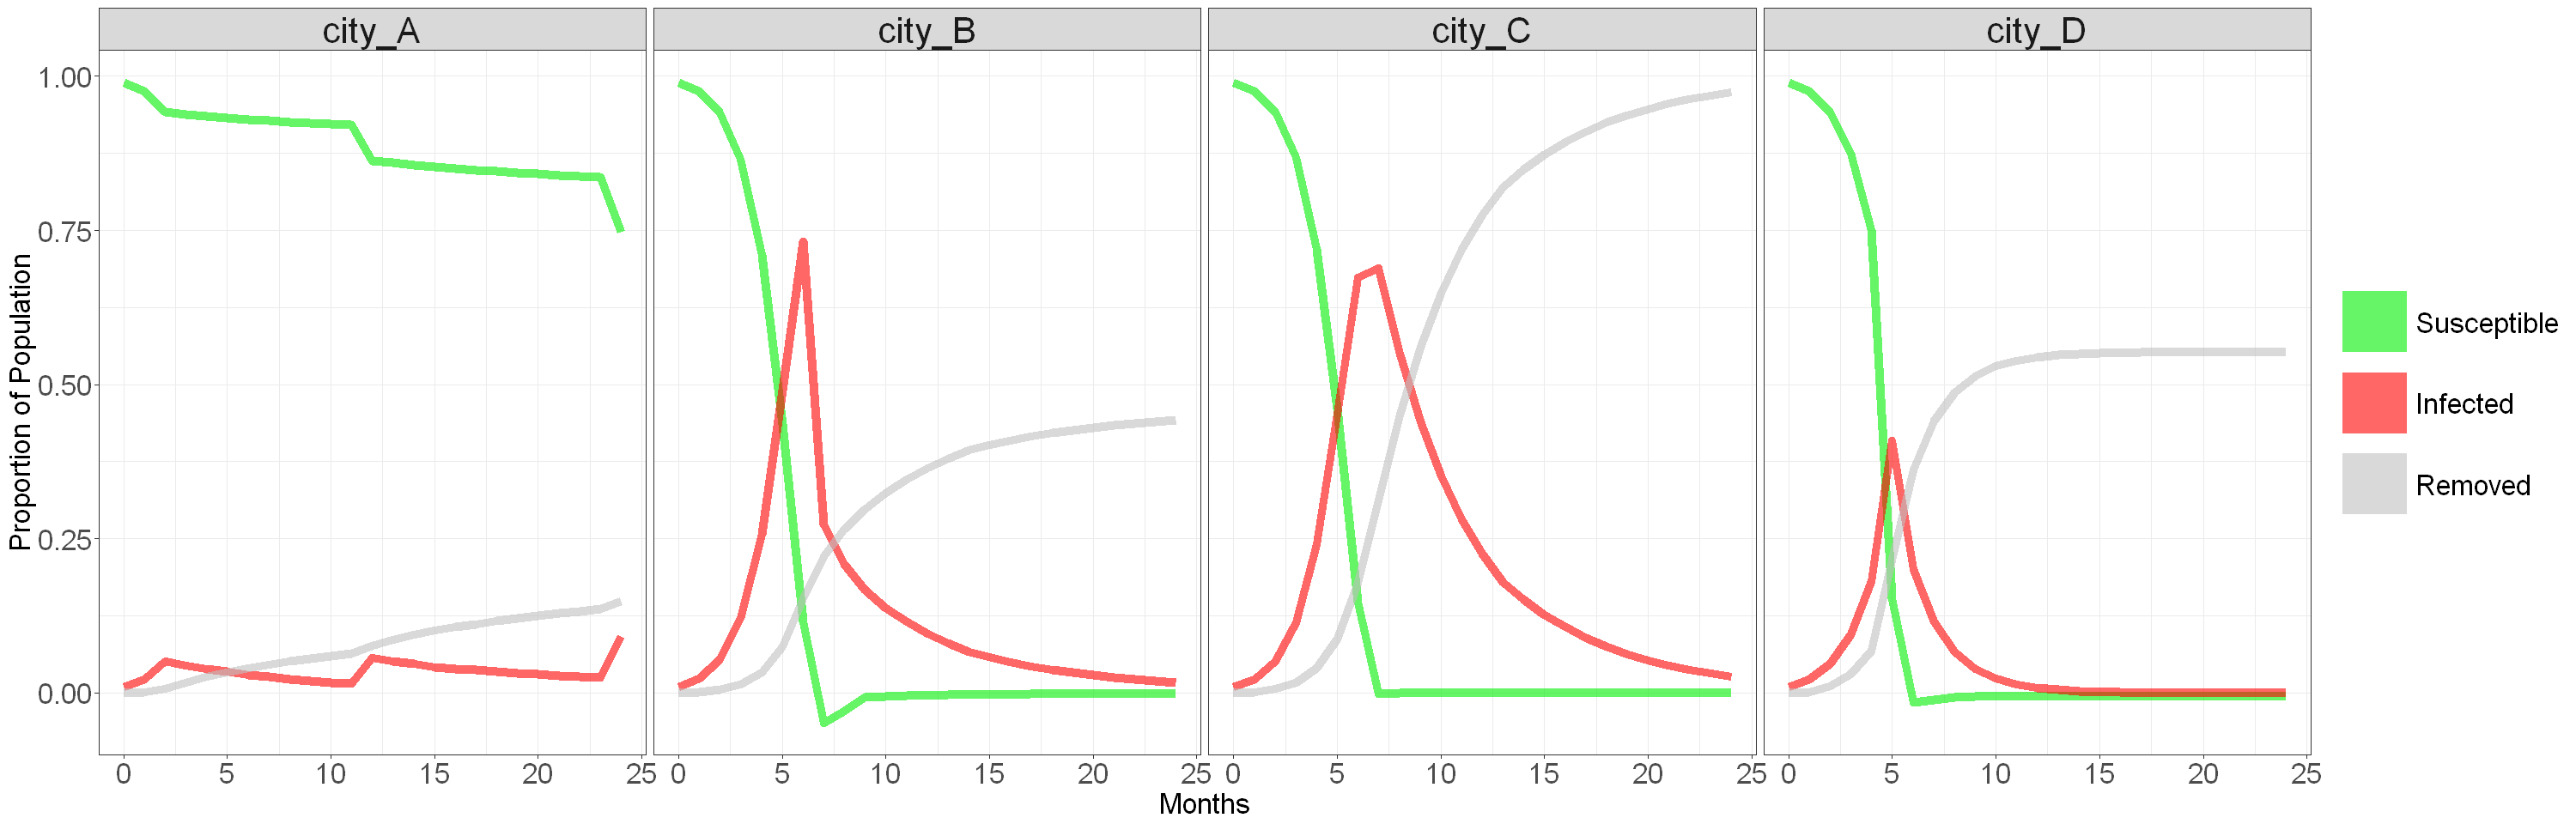

In [34]:
# All of the cities have the same starting conditions, just differnt events 
# to see the plots you need to scoll all the way to the bottom - see comment in cell above on how to remove

# 1. Initialize our data (same as Part 1) -----------------

beta  = 1.5  # initialize beta
gamma = 0.2  # initialize gamma

data            = data.frame("S" = as.double(), "I" = as.double(), "R" = as.double())
data["city_A",] = c(0.99, 0.01, 0)
data["city_B",] = c(0.99, 0.01, 0)
data["city_C",] = c(0.99, 0.01, 0)
data["city_D",] = c(0.99, 0.01, 0)


data$beta       = beta
data$gamma      = gamma
data$city       = rownames(data)

original.data   = data         # save this data - we will need this again

#3. Model over time( WITH event) -----------------

data = original.data

yes_event      = data                           # save starting values to master
yes_event$time = 0                              # add time column 

for (month in 1:24){                                # for a given time:
    a = time_step_event(data, month)
    data   = a                                  # re-initialize "data"
    a$time = month                                  # add time column
    yes_event = rbind(yes_event, a)             # save new values to "master"
}
  
yes_event$has_event = TRUE


# 4. Visualize our results -----------------
#again do not worry about this plotting nonsence

ggplot(melt(yes_event[,c("city", "has_event", "time", "S", "I", "R")], id = c("city", "has_event", "time")), 
       aes(x = time,  y = value, color = variable)) +  # assign x- and y-values
    geom_line(alpha = 0.6, size = 3) + 
    facet_grid(~city) + theme_bw() +                             # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                            # increase axis text size     
          axis.title   = element_text(size = 20),                            # increase axis title size
          legend.text  = element_text(size = 20),                            # increase legent text size
          legend.title = element_blank(),                                    # remove title in legend
          strip.text   = element_text(size=25)) +                            # increase plot title size
    ylab("Proportion of Population") +                                       # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0"),
                       labels = c("Susceptible", "Infected", "Removed")) +        # set colors
    guides(color = guide_legend(override = list(size = 20))) +               # enlarge legend symbols
    scale_linetype_manual(values=c("solid", "dotted"),
                          labels = c("yes_event")) + xlab("Months")


# Explore on your own time - how one event makes changes

Shock!
civil_unrest is happening in city_A
effect on beta: 1
effect on gamma: 1
event_beta: 3


At time 5 , if there had been no event: -------
                  S         I          R beta gamma   city
city_A 7.196262e-01 0.2405835 0.03979028  1.5   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920  1.5   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388  1.5   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737  1.5   0.2 city_D
But with event: -------
                  S         I          R beta gamma   city
city_A 2.002357e-01 0.3851037 0.03979028  1.5   0.2 city_A
city_B 3.746293e-02 0.6195179 0.34301920  1.5   0.2 city_B
city_C 2.401142e-02 0.4030447 0.57294388  1.5   0.2 city_C
city_D 6.668904e-05 0.4848059 0.51512737  1.5   0.2 city_D


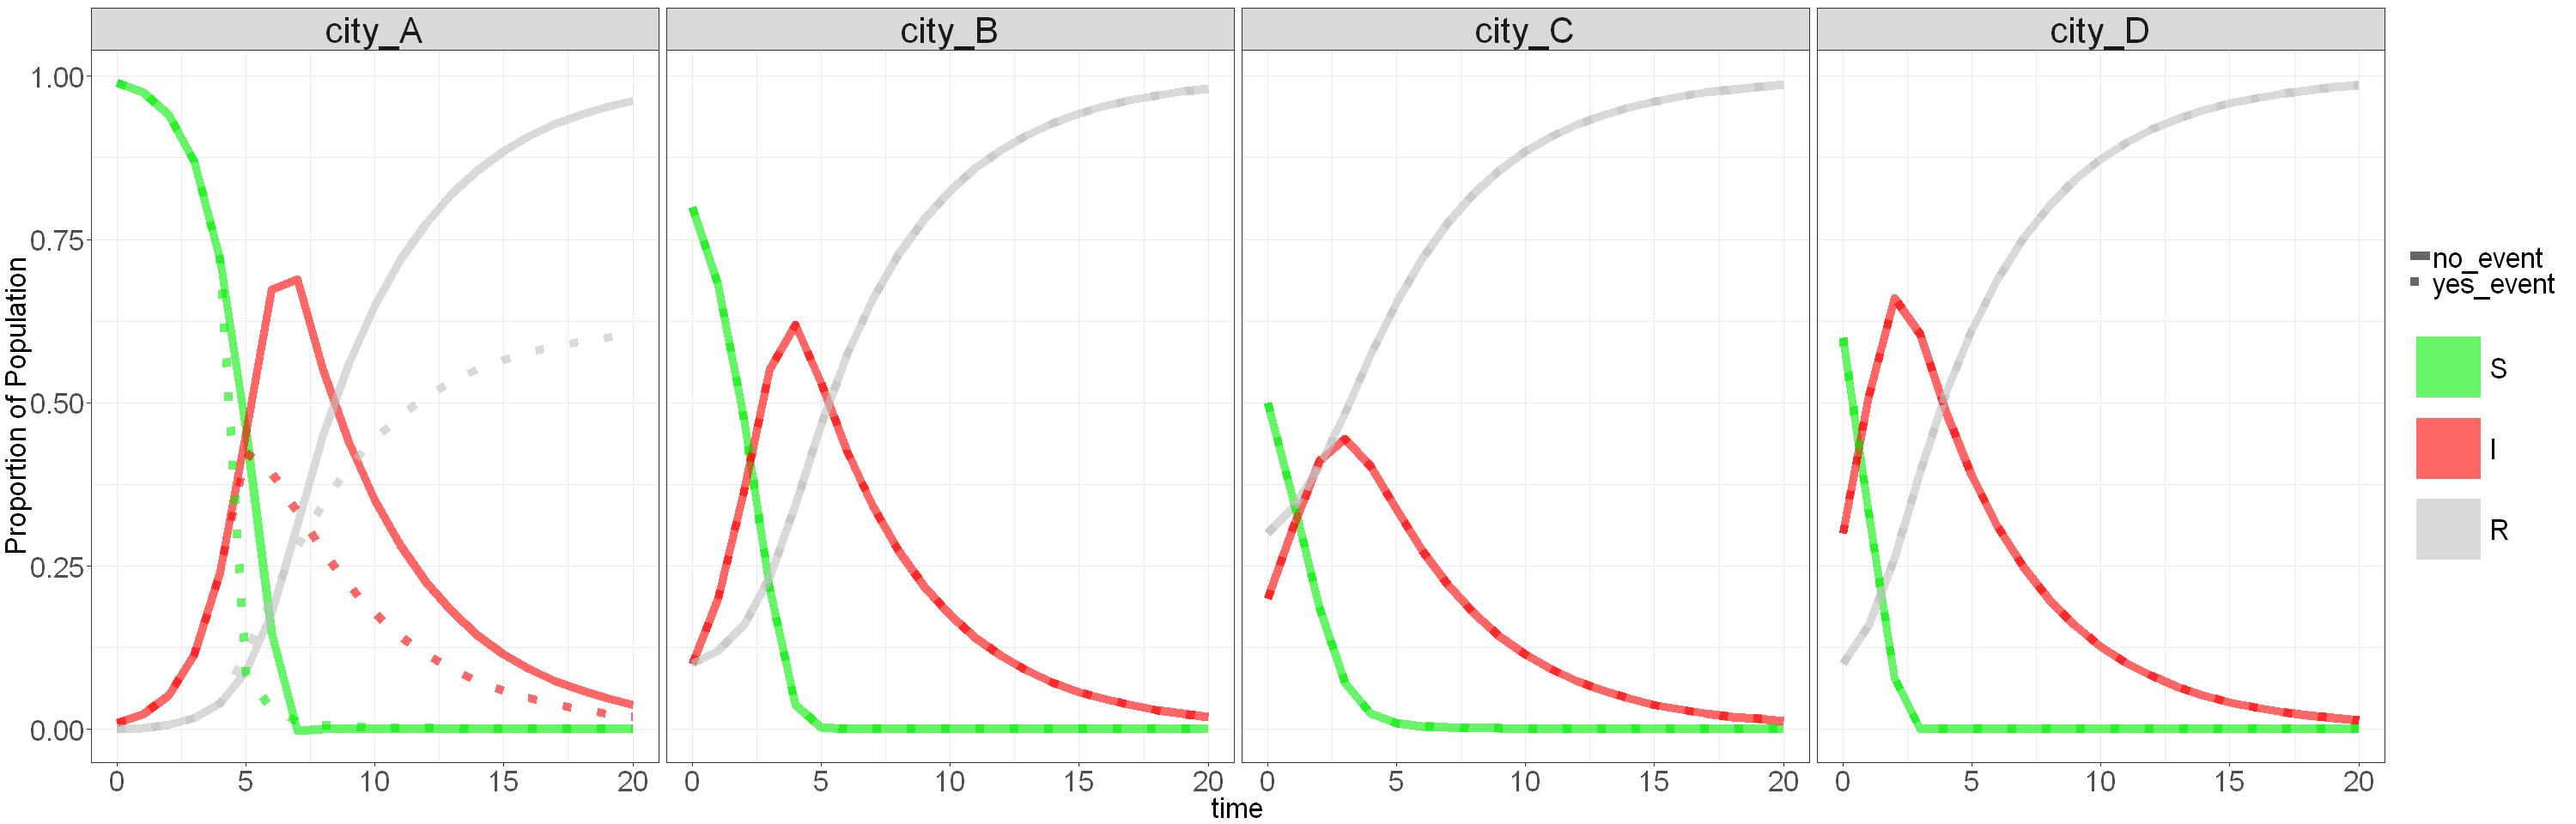

In [9]:
# 1. Initialize our data (same as Part 1) -----------------

beta  = 1.5  # initialize beta
gamma = 0.2  # initialize gamma

data            = data.frame("S" = as.double(), "I" = as.double(), "R" = as.double())
data["city_A",] = c(0.99, 0.01, 0)
data["city_B",] = c(0.80, 0.10, 0.10)
data["city_C",] = c(0.50, 0.20, 0.30)
data["city_D",] = c(0.60, 0.30, 0.10)

data$beta       = beta
data$gamma      = gamma
data$city       = rownames(data)

original.data   = data         # save this data - we will need this again


# 2. Model over time ( WITHOUT event) -----------------

no_event      = data                            # save starting values to master
no_event$time = 0                               # add time column 

for (i in 1:20){                                # for 20 time points:
    a      = time_step(data)                    # call function and save new values to "a"
    data   = a                                  # re-initialize "data"
    a$time = i                                  # add time column
    no_event = rbind(no_event, a)               # save new values to "master"
}
no_event$has_event  = FALSE


#3. Model over time( WITH event) -----------------

data = original.data

yes_event      = data                           # save starting values to master
yes_event$time = 0                              # add time column 

for (i in 1:20){                                # for a given time:
    if (i == 5){ a = time_step_event(data, i) } # have event happen @ time = 5
    else { a = time_step(data) }                # other times happen normally
    data   = a                                  # re-initialize "data"
    a$time = i                                  # add time column
    yes_event = rbind(yes_event, a)             # save new values to "master"
}
  
yes_event$has_event = TRUE


# 4. Visualize our results -----------------

master = rbind(no_event, yes_event)

ggplot(melt(master[,c("city", "has_event", "time", "S", "I", "R")], id = c("city", "has_event", "time")), 
       aes(x = time,  y = value, linetype = has_event, color = variable)) +  # assign x- and y-values
    geom_line(alpha = 0.6, size = 3) + 
    facet_grid(~city) + theme_bw() +                             # plot line graph with each city in separate plots
    theme(axis.text    = element_text(size = 20),                            # increase axis text size     
          axis.title   = element_text(size = 20),                            # increase axis title size
          legend.text  = element_text(size = 20),                            # increase legent text size
          legend.title = element_blank(),                                    # remove title in legend
          strip.text   = element_text(size=25)) +                            # increase plot title size
    ylab("Proportion of Population") +                                       # set y-axis title
    scale_color_manual(values = c("#00ee00", "#ff0000", "#c0c0c0")) +        # set colors
    guides(color = guide_legend(override = list(size = 20))) +               # enlarge legend symbols
    scale_linetype_manual(values=c("solid", "dotted"),
                          labels = c("no_event", "yes_event"))
